In [1]:
# !pip install keras-tuner --upgrade

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1. Load dữ liệu
data = pd.read_csv("features_mediapipe_merged_v2_xyz.csv")
X = data.drop(columns=["label", "handedness"])
y = data["label"]
# print(y.tolist()[:10])
manual_map = {
    -20: 26,  # space
    30: 27,   # del
    28: 28,   # autocmp
    # thêm nếu có
}
y = y.map(manual_map).fillna(y).astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [4]:
import pandas as pd
import numpy as np

def augment_flip_and_scale(X_train: np.ndarray, y_train: np.ndarray, scale_range=(0.9, 1.1)):
    # --- Flip ngang: đảo dấu trục X (giả định X ở vị trí 0, 3, 6, ...) ---
    X_flip = X_train.copy()
    X_flip[:, ::3] *= -1  # Flip các cột x: 0, 3, 6, ...

    # --- Scale ngẫu nhiên toàn bộ ---
    def random_scale(X, scale_range):
        scales = np.random.uniform(scale_range[0], scale_range[1], size=(X.shape[0], 1))
        return X * scales

    X_scaled = random_scale(X_train, scale_range)
    X_flip_scaled = random_scale(X_flip, scale_range)

    # --- Gộp lại tất cả ---
    X_aug = np.vstack([X_train, X_flip, X_scaled, X_flip_scaled])
    y_aug = np.concatenate([y_train] * 4)

    return X_aug, y_aug

# Apply augmentation
X_train, y_train = augment_flip_and_scale(X_train, y_train)
y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_test = y_test.to_numpy() if hasattr(y_test, "to_numpy") else y_test

print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


In [5]:
from sklearn.utils.class_weight import compute_class_weight

print(np.isnan(X_train).sum(), np.isinf(X_train).sum())
print("y_train unique values:", np.unique(y_train))
print("X_train min:", X_train.min(), "max:", X_train.max())
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

0 0
y_train unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
X_train min: -11.89435567430142 max: 11.744740491923473
Class Weights: {0: 1.096923471349827, 1: 0.8968766376690075, 2: 0.953692352272474, 3: 0.856523697512637, 4: 1.42203572912339, 5: 0.8237644159494792, 6: 0.8709339250091601, 7: 0.5861589467483184, 8: 0.9421213722640596, 9: 0.9391228955859435, 10: 0.8620286701522157, 11: 0.8607713354524604, 12: 1.142363197030985, 13: 1.3442934569161888, 14: 1.415215413875796, 15: 0.9901758852117566, 16: 0.9895117833437406, 17: 0.8842445723497256, 18: 1.0277687697426103, 19: 1.1151640732921522, 20: 0.9034672804442849, 21: 0.8987889545936748, 22: 0.9079151193633952, 23: 1.0753367849602895, 24: 1.0644747972334179, 25: 0.99350981075119, 26: 1.9036929922135706, 27: 1.525710515993296, 28: 1.2294683908045978}


In [6]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: []
Num GPUs: 0


In [8]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
from collections import Counter

# def compute_inverse_frequency_weights(y_train):
#     counts = Counter(y_train)
#     class_weights_dict = {cls: 1.0 / count for cls, count in counts.items()}

#     # (Optional) Normalize weights so that the maximum is 1.0
#     max_weight = max(class_weights_dict.values())
#     class_weights_dict = {cls: weight / max_weight for cls, weight in class_weights_dict.items()}

#     return class_weights_dict

# # Gọi sau khi đã augment dữ liệu
# class_weights_dict = compute_inverse_frequency_weights(y_train)

def f1_score(y_true, y_pred):
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int64')

    tp = K.sum(K.cast(K.equal(y_true, y_pred_labels), 'float32'))
    precision = tp / (K.sum(K.cast(K.not_equal(y_pred_labels, 0), 'float32')) + K.epsilon())
    recall = tp / (K.sum(K.cast(K.not_equal(y_true, 0), 'float32')) + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int("num_layers", 2, 2)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=128, max_value=256, step=128),
            activation="relu"
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float("dropout_rate", 0.5, 0.5, step=0.1)))

    model.add(layers.Dense(len(np.unique(y_train)), activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-5, 2e-5, sampling="log")
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_score]
    )
    return model



tuner = kt.RandomSearch(
    build_model,
    objective="val_f1_score",  # sử dụng F1 Score trên tập validation làm tiêu chí tối ưu
    max_trials=5,
    executions_per_trial=2,
    directory="keras_tuner_dir",
    project_name="asl_landmark_tuning"
)

tuner.search(X_train, y_train,
             validation_data=(X_test, y_test),
             epochs=25,
             batch_size=128,
             class_weight=class_weights_dict,
             callbacks=[
                 keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
             ])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
256               |256               |units_0
0.5               |0.5               |dropout_rate
128               |128               |units_1
1.057e-05         |1.057e-05         |learning_rate

Epoch 1/25
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0623 - f1_score: 0.0646 - loss: 4.2742 - val_accuracy: 0.3834 - val_f1_score: 0.3959 - val_loss: 2.3641
Epoch 2/25
 988/2675 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1813 - f1_score: 0.1878 - loss: 3.1729

KeyboardInterrupt: 

In [16]:
best_model = tuner.get_best_models(1)[0]
print(best_model.summary())

# print tuner best hyperparam
print(tuner.results_summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,445 (48.61 KB)

 Trainable params: 12,189 (47.61 KB)

 Non-trainable params: 256 (1.00 KB)

None
Results summary
Results in keras_tuner_dir/asl_landmark_tuning
Showing 10 best trials
Objective(name="val_f1_score", direction="min")

Trial 11 summary
Hyperparameters:
num_layers: 1
units_0: 128
dropout_rate: 0.5
learning_rate: 1.5661929982970205e-05
units_1: 128
Score: 0.35853420197963715

Trial 13 summary
Hyperparameters:
num_layers: 2
units_0: 128
dropout_rate: 0.5
learning_rate: 1.1472810349973977e-05
units_1: 256
Score: 0.3846266567707062

Trial 19 summary
Hyperparameters:
num_layers: 2
units_0: 320
dropout_rate: 0.5
learning_rate: 1.5823095532212414e-05
units_1: 320
Score: 0.6739291846752167

Trial 17 summary
Hyperparameters:
num_layers: 1
units_0: 128
dropout_rate: 0.5
learning_rate: 3.9609292205202444e-05
units_1: 384
Score: 0.692548930644989

Trial 29 summary
Hyperparameters:
num_layers: 1
units_0: 256
dropout_rate: 0.4
learning_rate: 2.403695176648779e-05
units_1: 384
Score: 0.7435656487941742

Trial 21 summary
Hyperparameters:
num_layers: 1
units_0: 448
dropout_rate: 0

In [10]:
best_model = tuner.get_best_models(1)[0]

best_model.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=35, batch_size=128)

best_model.export("asl_best_model_tf")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.2270 - f1_score: 0.2378 - loss: 2.8589 - val_accuracy: 0.5635 - val_f1_score: 0.5891 - val_loss: 1.7835
Epoch 2/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4169 - f1_score: 0.4336 - loss: 2.0468 - val_accuracy: 0.7252 - val_f1_score: 0.7574 - val_loss: 1.2540
Epoch 3/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5624 - f1_score: 0.5842 - loss: 1.5227 - val_accuracy: 0.8042 - val_f1_score: 0.8361 - val_loss: 0.9191
Epoch 4/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6641 - f1_score: 0.6886 - loss: 1.1712 - val_accuracy: 0.8508 - val_f1_score: 0.8824 - val_loss: 0.7015
Epoch 5/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7330 - f1_score: 0.7596 - loss: 0.9383 - val_accuracy: 0.8821 - val_f1_score: 0.9137 - val_loss: 0.5590
Epoch 6/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7827 - f1_score: 0.8103 - loss: 0.7738 - val_accuracy: 0.9001 - val_f1_

In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model("asl_best_model_tf")
tflite_model = converter.convert()

with open("asl_landmark_model.tflite", "wb") as f:
    f.write(tflite_model)

669/669 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


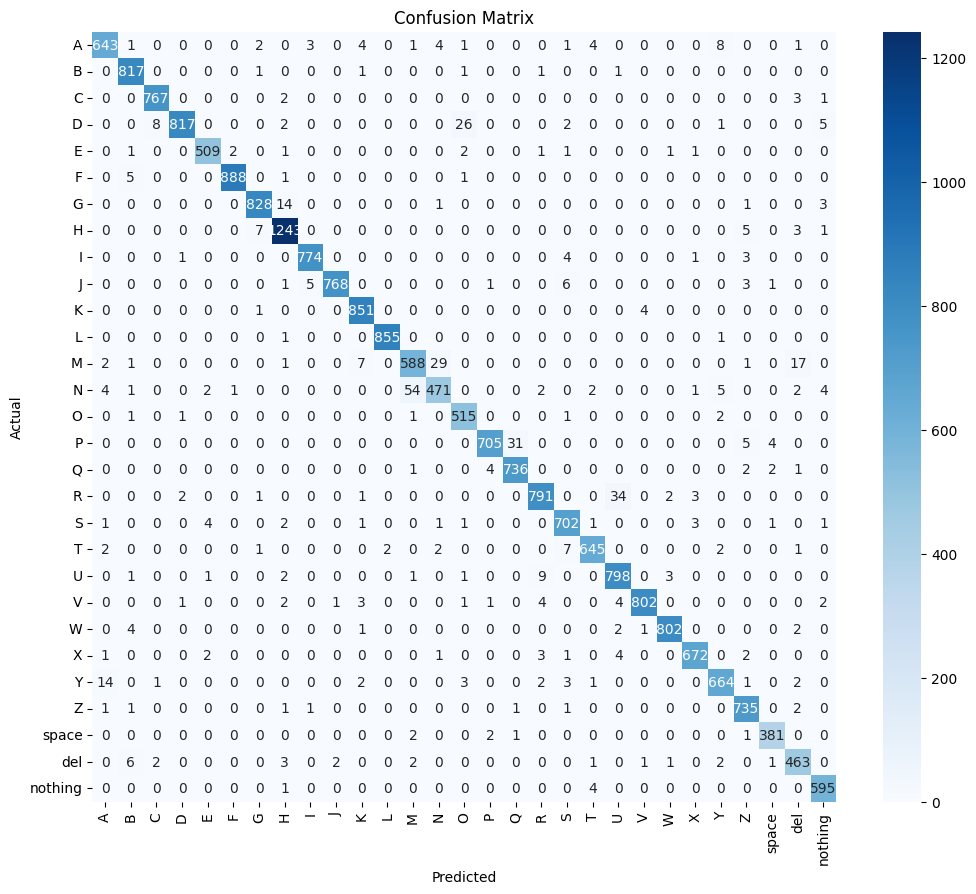

Overall Accuracy: 0.9734


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = y_test
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_labels)

label_names = [chr(ord('A') + i) for i in range(26)] + ['space', 'del', 'nothing']  # nếu dùng 29 lớp

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names[:cm.shape[0]],
            yticklabels=label_names[:cm.shape[0]])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred_labels, labels=np.unique(y_true))

report_df = pd.DataFrame({
    'Label': label_names[:len(precision)],
    'Precision': np.round(precision, 3),
    'Recall': np.round(recall, 3),
    'F1-score': np.round(f1, 3),
    'Support': support
})

overall_accuracy = np.mean(y_true == y_pred_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

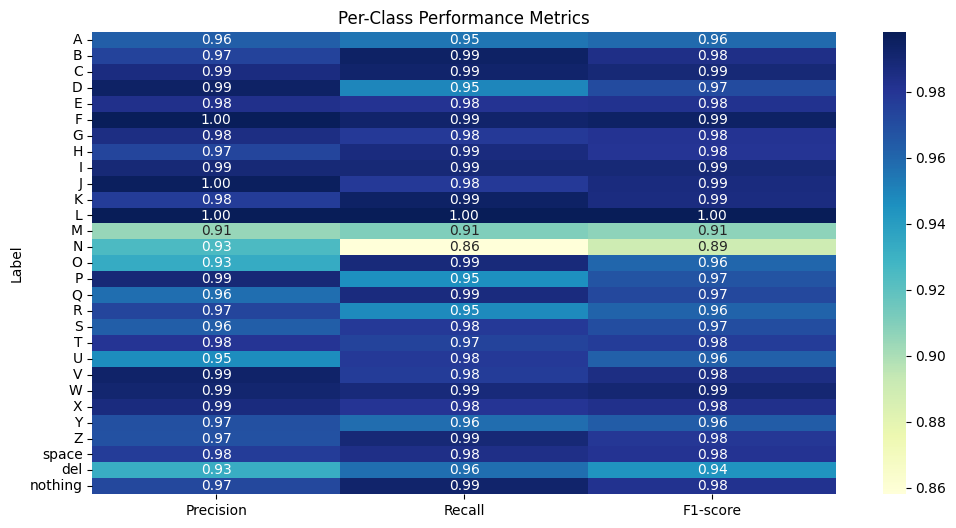

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(report_df.set_index("Label")[["Precision", "Recall", "F1-score"]],
            annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Per-Class Performance Metrics")
plt.show()